# Monitoring self-consistent field calculations

The `self_consistent_field` function takes as the `callback`
keyword argument one function to be called after each iteration.
This function gets passed the complete internal state of the SCF
solver and can thus be used both to monitor and debug the iterations
as well as to quickly patch it with additional functionality.

This example discusses a few aspects of the `callback` function
taking again our favourite silicon example.

We setup silicon in an LDA model using `AtomsBuilder`
to build a bulk silicon lattice,
(see AtomsBase integration for more details.

In [1]:
using DFTK
using AtomsBuilder
using PseudoPotentialData

pseudopotentials = PseudoFamily("dojo.nc.sr.lda.v0_4_1.standard.upf")
model = model_DFT(bulk(:Si); functionals=LDA(), pseudopotentials)
basis = PlaneWaveBasis(model; Ecut=5, kgrid=[3, 3, 3]);

DFTK already defines a few callback functions for standard
tasks. One example is the usual convergence table,
which is defined in the callback `ScfDefaultCallback`.
It has a few options to customize printing. For example an estimate
of the total memory consumption on host (main RAM) and an eventual
GPU device is printed if one uses the callback

In [2]:
callback = ScfDefaultCallback(show_memory=true)
scfres = self_consistent_field(basis; tol=1e-3, callback);

n     Energy            log10(ΔE)   log10(Δρ)   α      Diag   Δtime    Memory
---   ---------------   ---------   ---------   ----   ----   ------   ------
  1   -8.457147499202                   -0.89   0.80    5.0   25.7ms  1.13GiB
  2   -8.460031188274       -2.54       -1.72   0.80    1.0   32.5ms  1.14GiB
  3   -8.460190521931       -3.80       -2.87   0.80    1.5   18.6ms  1.15GiB
  4   -8.460214753004       -4.62       -2.94   0.80    3.2   23.2ms  1.16GiB
  5   -8.460214872561       -6.92       -3.01   0.80    1.0   17.7ms  1.16GiB


Another example is `ScfSaveCheckpoints`, which stores the state
of an SCF at each iterations to allow resuming from a failed
calculation at a later point.
See Saving SCF results on disk and SCF checkpoints for details
how to use checkpointing with DFTK.

In this example we define a custom callback, which plots
the change in density at each SCF iteration after the SCF
has finished. This example is a bit artificial, since the norms
of all density differences is available as `scfres.history_Δρ`
after the SCF has finished and could be directly plotted, but
the following nicely illustrates the use of callbacks in DFTK.

To enable plotting we first define the empty canvas
and an empty container for all the density differences:

In [3]:
using Plots
p = plot(; yaxis=:log)
density_differences = Float64[];

The callback function itself gets passed a named tuple
similar to the one returned by `self_consistent_field`,
which contains the input and output density of the SCF step
as `ρin` and `ρout`. Since the callback gets called
both during the SCF iterations as well as after convergence
just before `self_consistent_field` finishes we can both
collect the data and initiate the plotting in one function.

In [4]:
using LinearAlgebra

function plot_callback(info)
    if info.stage == :finalize
        plot!(p, density_differences, label="|ρout - ρin|", markershape=:x)
    else
        push!(density_differences, norm(info.ρout - info.ρin))
    end
    info
end
callback = ScfDefaultCallback() ∘ plot_callback;

Notice that for constructing the `callback` function we chained the `plot_callback`
(which does the plotting) with the `ScfDefaultCallback`. The latter is the function
responsible for printing the usual convergence table. Therefore if we simply did
`callback=plot_callback` the SCF would go silent. The chaining of both callbacks
(`plot_callback` for plotting and `ScfDefaultCallback()` for the convergence table)
makes sure both features are enabled. We run the SCF with the chained callback …

In [5]:
scfres = self_consistent_field(basis; tol=1e-5, callback);

n     Energy            log10(ΔE)   log10(Δρ)   α      Diag   Δtime 
---   ---------------   ---------   ---------   ----   ----   ------
  1   -8.457204648228                   -0.89   0.80    5.0    593ms
  2   -8.460033767768       -2.55       -1.72   0.80    1.0    239ms
  3   -8.460188982439       -3.81       -2.91   0.80    1.5   18.1ms
  4   -8.460214701505       -4.59       -2.92   0.80    3.0   22.3ms
  5   -8.460214975858       -6.56       -3.13   0.80    1.0   17.2ms
  6   -8.460215135639       -6.80       -5.08   0.80    1.0   17.3ms


… and show the plot

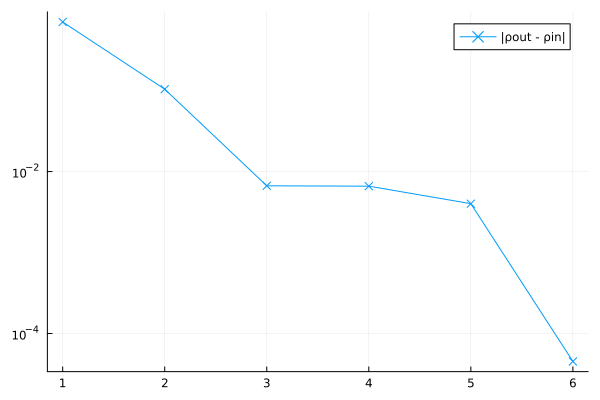

In [6]:
p

The `info` object passed to the callback contains not just the densities
but also the complete Bloch wave (in `ψ`), the `occupation`, band `eigenvalues`
and so on.
See [`src/scf/self_consistent_field.jl`](https://dftk.org/blob/master/src/scf/self_consistent_field.jl#L101)
for all currently available keys.

> **Debugging with callbacks**
>
> Very handy for debugging SCF algorithms is to employ callbacks
> with an `@infiltrate` from [Infiltrator.jl](https://github.com/JuliaDebug/Infiltrator.jl)
> to interactively monitor what is happening each SCF step.